 ## Model Selection: Research Paper Summarization

This model is by Janani Arunachalam and Kevin Thomas. Notebook can be found here: https://github.com/jananiarunachalam/Research-Paper-Summarization/blob/master/Abstractive_Summarization.ipynb

In [9]:
!pip install tqdm==4.36.1

In [10]:
!pip install rogue

In [11]:
!pip install pandas

In [6]:
import numpy as np  
import pandas as pd 
import re           
import glob
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import keras
import warnings
import nltk


nltk.download('stopwords')
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /Users/sana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Reading Pickle'd file which has data stored in a dataframe
# with headings: "text", "filenames", "highlights", "body"


data = pd.read_pickle('/Users/sana/code/BertSumAbs/data/papers.pkl')

## Text Preprocessing

In [13]:
!pip install spacy

  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.36.1
    Uninstalling tqdm-4.36.1:
      Successfully uninstalled tqdm-4.36.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
simpletaxifare 1.0 requires numpy==1.18.5, but you have numpy 1.17.2 which is incompatible.
simpletaxifare 1.0 requires six==1.15.0, but you have six 1.14.0 which is incompatible.
taxifaremodel 1.0 requires numpy==1.18.5, but you have numpy 1.17.2 which is incompatible.


In [15]:
from spacy.lang.en.stop_words import STOP_WORDS
 
def clean_body(text):
    newText = text.lower()
    newText = re.sub('[^\w\s\d\.]','',newText)
    newText = ' '.join(newText.split())
    tokens = [w for w in newText.split() if not w in STOP_WORDS]
    long_words=[]
    for i in tokens:
        if len(i)>=3:
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_body = []
for t in data['body']:
    cleaned_body.append(clean_body(t))

#cleaned_body[:5]

In [16]:
# Preprocessing "highlight" text


def clean_highlight(text):
  newText = text.lower()
  newText = re.sub('[^\w\s\d\.]','',newText)
  newText = ' '.join(newText.split())
  newText = '_START_ '+ newText + ' _END_'
  return newText

cleaned_highlight = []
for t in data['highlights']:
    cleaned_highlight.append(clean_highlight(t))

#cleaned_highlight[:5]

In [17]:
# Storing preprocessed data in the dataframe


data['cleaned_highlights'] = cleaned_highlight
data['cleaned_body'] = cleaned_body

In [18]:
data = data[:5000]

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 27 to 6950
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                5000 non-null   object
 1   filenames           5000 non-null   object
 2   highlights          5000 non-null   object
 3   body                5000 non-null   object
 4   cleaned_highlights  5000 non-null   object
 5   cleaned_body        5000 non-null   object
dtypes: object(6)
memory usage: 273.4+ KB


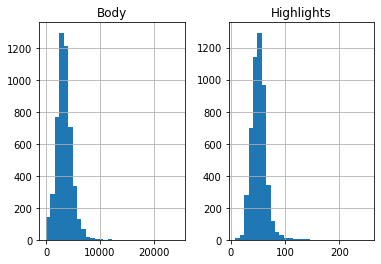

In [20]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

for i in data['cleaned_body']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_highlights']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Body':text_word_count, 'Highlights':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [21]:

max_len_body = 1000
max_len_highlight = 50

In [22]:

# Converting cleaned data into strings


data.cleaned_body = data.cleaned_body.apply(lambda x: str(x))
data.cleaned_highlights = data.cleaned_highlights.apply(lambda x: str(x))

In [23]:
# Splitting data into training and test sets
# Test set is 20% of total data


from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data['cleaned_body'],data['cleaned_highlights'],test_size=0.2,random_state=0,shuffle=True)

In [24]:
# Tokenizing "body"
x_tok = Tokenizer()
x_tok.fit_on_texts(list(x_train))

# Converting text to number sequences
x_train = x_tok.texts_to_sequences(x_train) 
x_test = x_tok.texts_to_sequences(x_test)

# Padding zero upto maximum length
x_train = pad_sequences(x_train,  maxlen=max_len_body, padding='post') 
x_test = pad_sequences(x_test, maxlen=max_len_body, padding='post')

# Total number of words
x_vocab_size = len(x_tok.word_index) +1

In [25]:
# Tokenizing "highlights"
y_tok = Tokenizer()
y_tok.fit_on_texts(list(y_train))

# Converting text to number sequences
y_train = y_tok.texts_to_sequences(y_train) 
y_test = y_tok.texts_to_sequences(y_test)

# Padding zero upto maximum length
y_train = pad_sequences(y_train,  maxlen=max_len_highlight, padding='post') 
y_test = pad_sequences(y_test, maxlen=max_len_highlight, padding='post')

# Word count
y_vocab_size = len(y_tok.word_index) +1

## Model Definition


Attention Layer required to remember context information. As there is no Keras implementation for Attention Layer we have found a third-party resource to aid in our model. Reference: https://github.com/thushv89/attention_keras/blob/master/layers/attention.py

In [26]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


## Model Creation

In [27]:
from keras import backend as K 


K.clear_session() 
latent_dim = 50 


# Encoder 
encoder_inputs = Input(shape=(max_len_body,)) 
enc_emb = Embedding(x_vocab_size, latent_dim,trainable=True)(encoder_inputs) 

# 1st LSTM Layer
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

# 2nd LSTM Layer
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

# 3rd LSTM Layer
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Decoder 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_vocab_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

# Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Model Definition
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

2021-11-14 14:43:34.132150: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 50)     12730400    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 1000, 50), ( 20200       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

RMSProp was found to be the best optimizer for text summarization and sparse categorical crossentropy was found to be the best loss functiom from this reference: https://hackernoon.com/text-summarization-using-keras-models-366b002408d9
Sparse categorical cross entropy is used as the loss function because it automatically converts an integer sequence to a one-hot encoded vector, hence requiring less memory.

In [28]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [29]:
es = EarlyStopping(patience = 3, monitor='val_loss', mode='min', verbose=1)

## Model Training

In [30]:
x_train.shape

(4000, 1000)

In [31]:
y_train[:,:-1].shape

(4000, 49)

In [32]:
y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:].shape

(4000, 49, 1)

In [33]:
history = model.fit([x_train,y_train[:,:-1]], 
                    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                    epochs=30, callbacks=[es],
                    batch_size=128,
                    validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

2021-11-14 14:44:22.344587: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
32/32 [==============================] - 381s 12s/step - loss: 8.0085 - val_loss: 6.6266
Epoch 2/30
32/32 [==============================] - 322s 10s/step - loss: 6.8006 - val_loss: 6.4239
Epoch 3/30
32/32 [==============================] - 287s 9s/step - loss: 6.6769 - val_loss: 6.2732
Epoch 4/30
32/32 [==============================] - 351s 11s/step - loss: 6.5423 - val_loss: 6.1374
Epoch 5/30
32/32 [==============================] - 391s 12s/step - loss: 6.4434 - val_loss: 6.0567
Epoch 6/30
32/32 [==============================] - 337s 10s/step - loss: 6.3655 - val_loss: 5.9900
Epoch 7/30
32/32 [==============================] - 308s 10s/step - loss: 6.2972 - val_loss: 5.9391
Epoch 8/30
32/32 [==============================] - 322s 10s/step - loss: 6.2369 - val_loss: 5.9042
Epoch 9/30
32/32 [==============================] - 335s 10s/step - loss: 6.1875 - val_loss: 5.8734
Epoch 10/30
32/32 [==============================] - 351s 11s/step - loss: 6.1343 - val_loss: 5.8462


In [27]:
pwd

'/Users/sana/code/BertSumAbs'

In [34]:
model.save('/Users/sana/code/BertSumAbs')

2021-11-14 17:32:20.158377: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/sana/code/BertSumAbs/assets


INFO:tensorflow:Assets written to: /Users/sana/code/BertSumAbs/assets


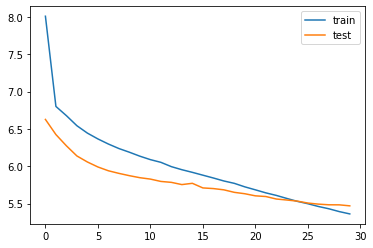

In [35]:
# Visualizing training ans test loss functions


from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [36]:
reverse_target_word_index=y_tok.index_word 
reverse_source_word_index=x_tok.index_word 
target_word_index=y_tok.word_index

In [37]:
# Encoder Inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder Inference
# Below tensors hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_body,latent_dim))

# Getting decoder sequence embeddings
dec_emb2= dec_emb_layer(decoder_inputs)

# Predicting the next word in the sequence
# Setting the initial states to the previous time step states
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention Inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Dense softmax layer to calculate probability distribution over target vocab
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final Decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [38]:
# Function to implement inference



def decode_sequence(input_seq):
    # Encoding input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generating empty target sequence of length 1
    target_seq = np.zeros((1,1))

    # Taking the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        try:
            sampled_token = reverse_target_word_index[sampled_token_index]
        except:
            sampled_token = reverse_target_word_index[np.random.randint(1, len(reverse_target_word_index))]
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_highlight-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Function to convert interger sequence to word sequence for highlights.

In [39]:
def seq2highlights(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

In [41]:
reference = []
hypothesis = []
for i in range(10):
  print("Highlights:")
  #print(seq2summary(y_test[i]))
  reference.append(seq2highlights(y_test[i]))
  print("\n")
  print("Predicted summary:")
  print(decode_sequence(x_test[i].reshape(1,max_len_body)))
  hypothesis.append(decode_sequence(x_test[i].reshape(1,max_len_body)))
  print("\n")
  print("\n")

Highlights:


Predicted summary:
 we propose a novel model for the health data we propose a novel model for the model of the model of the number of the number of the number of the number of the number of the number of the number of the number of the number of the




Highlights:


Predicted summary:
 we propose a new problem for the problem of the problem we propose a new problem for the problem of the problem we propose a new model for the problem of the problem we show the proposed approach to the new problem ggp cfd animals outofvocabulary multidea directions kirchhoff




Highlights:


Predicted summary:
 we propose a new model for the model of the model of the model of the model of the model of the model of the model of the model of the model of the model distinguishing evaporating accept 111000 lysmer pz ease analysts tam walking epidemiologic confirms rewritten central




Highlights:


Predicted summary:
 we propose a new problem for the problem of the problem we propose a new 

## Calculating Rouge Scores

In [42]:
! pip install rouge

In [43]:

from rouge import Rouge


In [44]:

score = Rouge()

In [45]:
score.get_scores(hypothesis, reference, avg = True)

{'rouge-1': {'r': 0.12351521683929426,
  'p': 0.2090901116427432,
  'f': 0.15309055254340953},
 'rouge-2': {'r': 0.0232649476127737,
  'p': 0.04382234432234432,
  'f': 0.03031315692279345},
 'rouge-l': {'r': 0.10470265520852776,
  'p': 0.17769059011164273,
  'f': 0.13006463998402845}}